In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from datetime import datetime

# Load CSV files
air_reserve = pd.read_csv('air_reserve.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
air_store_info = pd.read_csv('air_store_info.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
air_visit_data = pd.read_csv('air_visit_data.csv')
sample_submission = pd.read_csv('sample_submission.csv')
date_info = pd.read_csv('date_info.csv')

# Display the first few rows of each dataset
print(air_reserve.head())
print(hpg_reserve.head())
print(air_store_info.head())
print(hpg_store_info.head())
print(store_id_relation.head())
print(air_visit_data.head())
print(sample_submission.head())
print(date_info.head())

# Convert datetime columns to datetime format
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])

hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['reserve_datetime'] = pd.to_datetime(hpg_reserve['reserve_datetime'])

air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

# Check for missing values
print(air_reserve.isnull().sum())
print(hpg_reserve.isnull().sum())
print(air_visit_data.isnull().sum())


           air_store_id       visit_datetime     reserve_datetime  \
0  air_877f79706adbfb06  2016-01-01 19:00:00  2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00   
3  air_877f79706adbfb06  2016-01-01 20:00:00  2016-01-01 16:00:00   
4  air_db80363d35f10926  2016-01-01 20:00:00  2016-01-01 01:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 6  
3                 2  
4                 5  
           hpg_store_id       visit_datetime     reserve_datetime  \
0  hpg_c63f6f42e088e50f  2016-01-01 11:00:00  2016-01-01 09:00:00   
1  hpg_dac72789163a3f47  2016-01-01 13:00:00  2016-01-01 06:00:00   
2  hpg_c8e24dcf51ca1eb5  2016-01-01 16:00:00  2016-01-01 14:00:00   
3  hpg_24bb207e5fd49d4a  2016-01-01 17:00:00  2016-01-01 11:00:00   
4  hpg_25291c542ebb3bc2  2016-01-01 17:00:00  2016-01-01 03:00:00   

   reserve_visitors  
0               

In [2]:
# Merge air visit data with air store info
air_data = pd.merge(air_visit_data, air_store_info, on='air_store_id', how='left')

# Merge air reserve data with air store info to add reservation info
air_reserve_merged = pd.merge(air_reserve, air_store_info, on='air_store_id', how='left')

# Group reservation data by date to get total visitors by date
air_reserve_grouped = air_reserve_merged.groupby('visit_datetime')['reserve_visitors'].sum().reset_index()
air_reserve_grouped['visit_datetime'] = pd.to_datetime(air_reserve_grouped['visit_datetime'])

# Merge reservation data with visit data (using the date)
merged_data = pd.merge(air_data, air_reserve_grouped, left_on='visit_date', right_on='visit_datetime', how='left')

# Fill missing values with 0 (no reservations)
merged_data['reserve_visitors'].fillna(0, inplace=True)

# Add weekday information
merged_data['day_of_week'] = merged_data['visit_date'].dt.dayofweek

# Add holiday flag
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'], errors='coerce')

merged_data = pd.merge(merged_data, date_info[['calendar_date', 'holiday_flg']], 
                       left_on='visit_date', right_on='calendar_date', how='left')

# Convert categorical variables to numerical
le_genre = LabelEncoder()
merged_data['air_genre_name'] = le_genre.fit_transform(merged_data['air_genre_name'])

# Scaling the numerical columns
scaler = MinMaxScaler()
merged_data[['reserve_visitors', 'air_genre_name']] = scaler.fit_transform(merged_data[['reserve_visitors', 'air_genre_name']])

# Drop unnecessary columns
merged_data.drop(['calendar_date'], axis=1, inplace=True)

print(merged_data.head())


           air_store_id visit_date  visitors  air_genre_name  \
0  air_ba937bf13d40fb24 2016-01-13        25        0.307692   
1  air_ba937bf13d40fb24 2016-01-14        32        0.307692   
2  air_ba937bf13d40fb24 2016-01-15        29        0.307692   
3  air_ba937bf13d40fb24 2016-01-16        22        0.307692   
4  air_ba937bf13d40fb24 2016-01-18         6        0.307692   

                  air_area_name   latitude   longitude visit_datetime  \
0  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599            NaT   
1  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599            NaT   
2  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599            NaT   
3  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599            NaT   
4  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599            NaT   

   reserve_visitors  day_of_week  holiday_flg  
0               0.0            2            0  
1               0.0            3            0  
2               0.0            4

In [3]:

#drop visit_datetime
merged_data.drop(['visit_datetime'], axis=1, inplace=True)
print(merged_data.isnull().sum())

air_store_id        0
visit_date          0
visitors            0
air_genre_name      0
air_area_name       0
latitude            0
longitude           0
reserve_visitors    0
day_of_week         0
holiday_flg         0
dtype: int64


In [4]:
# Check the types of the columns
print(merged_data.dtypes)

# Identify which columns are not numeric
non_numeric_columns = merged_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)


air_store_id                object
visit_date          datetime64[ns]
visitors                     int64
air_genre_name             float64
air_area_name               object
latitude                   float64
longitude                  float64
reserve_visitors           float64
day_of_week                  int64
holiday_flg                  int64
dtype: object
Non-numeric columns: Index(['air_store_id', 'air_area_name'], dtype='object')


In [5]:
#label encode air_store_id and air_area_name
le = LabelEncoder()
merged_data['air_store_id'] = le.fit_transform(merged_data['air_store_id'])
merged_data['air_area_name'] = le.fit_transform(merged_data['air_area_name'])



In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Prepare features and target variable (visitors)
X = merged_data[['air_store_id', 'air_genre_name', 'reserve_visitors', 'day_of_week', 'holiday_flg']].values
y = merged_data['visitors'].values

# Reshape the data to a sequence format
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to 3D: [samples, time steps, features]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(201686, 1, 5) (201686,) (50422, 1, 5) (50422,)


In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input

# Define the model

input_shape = X_train.shape[1:]

inputs = Input(shape=input_shape)
encoded = LSTM(64, activation='tanh', return_sequences=False)(inputs)  # Use 'tanh' for LSTM
decoded = RepeatVector(1)(encoded)  # Repeat the context for the next time step
decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)  # Decoder
decoded = TimeDistributed(Dense(1))(decoded)  # Output layer: 1 for the number of visitors

model = Model(inputs, decoded)
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                17920     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 64)            0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 1, 64)             33024     
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 1)             65        
 tributed)                                                       
                                                                 
Total params: 51,009
Trainable params: 51,009
Non-trainable

In [12]:
# Predict using the trained model
y_pred = model.predict(X_test)

1576/1576 [==============================] - 8s 4ms/step


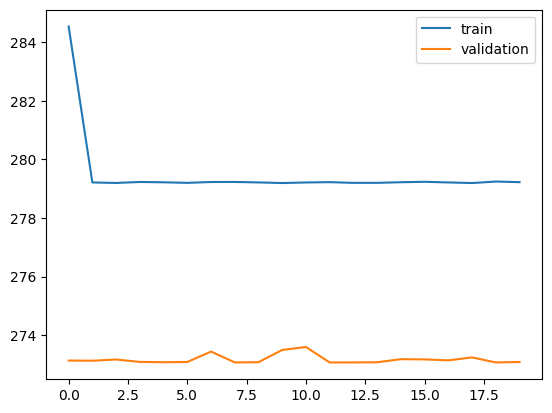

In [13]:
#plot
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
